In [3]:
import pandas as pd
import numpy as np

import json
from pandas.io.json import json_normalize
from pprint import pprint

#import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
#import cufflinks as cf
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt

from scipy import stats
from scipy.fftpack import fft

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_absolute_error
from sklearn.utils import shuffle
from sklearn.linear_model import ARDRegression, LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, cross_val_score

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning:

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.



## Data cleaning

In [3]:
df = pd.read_csv('..\UseCase_3_Datasets\sales_granular.csv')

In [4]:
df.head()

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
0,10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,60.0,150.0,600.0,NaN,NaN,NaN
4,10085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
for index, boolean in enumerate(df.store_code.duplicated()):
    if boolean: print index

33
34
35


In [6]:
# inspect duplicate
df.loc[df.store_code == df.store_code[33]]

,store_code,8/3/15 9:00,8/3/15 10:00,8/3/15 11:00,8/3/15 12:00,8/3/15 13:00,8/3/15 14:00,8/3/15 15:00,8/3/15 16:00,8/3/15 17:00,...,6/25/17 13:00,6/25/17 14:00,6/25/17 15:00,6/25/17 16:00,6/25/17 17:00,6/25/17 18:00,6/25/17 19:00,6/25/17 20:00,6/25/17 21:00,6/25/17 22:00
32,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
33,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
34,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN
35,11028,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,30.0,90.0,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Lines 33, 34 and 35 are identical to line 32
df.drop(df.index[[33, 34, 35]], inplace=True)

In [8]:
df.store_code.is_unique

True

#### DateTime transformation

In [9]:
df.set_index('store_code', inplace=True)

In [10]:
df.columns = pd.to_datetime(df.columns)

In [11]:
df.head()

,2015-08-03 09:00:00,2015-08-03 10:00:00,2015-08-03 11:00:00,2015-08-03 12:00:00,2015-08-03 13:00:00,2015-08-03 14:00:00,2015-08-03 15:00:00,2015-08-03 16:00:00,2015-08-03 17:00:00,2015-08-03 18:00:00,...,2017-06-25 13:00:00,2017-06-25 14:00:00,2017-06-25 15:00:00,2017-06-25 16:00:00,2017-06-25 17:00:00,2017-06-25 18:00:00,2017-06-25 19:00:00,2017-06-25 20:00:00,2017-06-25 21:00:00,2017-06-25 22:00:00
store_code,,,,,,,,,,,,,,,,,,,,,
10055,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10079,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,30.0,60.0,150.0,600.0,NaN,NaN,NaN
10085,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Clean impossible value

In [12]:
#remove all negative value as t is impossible to have negative value for sales volume
df = df.applymap(lambda x: 0 if x < 0 else x)

## Timeframe resample

In [94]:
df2 = df.T

In [95]:
df3 = df2.resample('W').sum()

In [96]:
df3.shape

(99, 903)

In [97]:
df3.dropna(axis=1, how='all', inplace=True)

In [98]:
df3.shape

(99, 903)

In [99]:
df3.head()

store_code,10055,10077,10079,10081,10085,10086,10111,10176,10377,10384,...,84089,84125,84128,84146,84219,84223,84351,84608,84658,85011
2015-08-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3870.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3150.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,6600.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-08-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,10320.0,NaN,NaN,NaN,NaN,NaN,NaN
2015-09-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,7290.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Creation of a dataset (X and y)

In [223]:
X=[]
y=[]


for index, column in enumerate(df3):
    if index % 50 == 0:
        print index, len(X)
    for stop in np.arange(20, len(df3[column])):
        start = stop - 20
            
        if not (df3[column][start:stop].isnull().values.any() or np.isnan(df3[column][stop])):
            X.append([df3[column][start:stop].values])
            y.append([df3[column][stop]])


0 0
50 1317
100 2233
150 2941
200 3784
250 4366
300 4924
350 5193
400 5405
450 5560
500 6133
550 6271
600 6670
650 6999
700 7252
750 7412
800 7647
850 8835
900 10118


In [224]:
X = np.array(X).squeeze()

In [225]:
y = np.array(y).squeeze()

#### Remove outliers: remove picks/abnormaly high sales volume

In [226]:
len(y)

10189

In [236]:
n = int(len(y)*0.05)

In [237]:
X_1d = X.flatten()
valueToRemove = X_1d[np.argsort(X_1d)[-n:]]

In [256]:
X_out, y_out = [], []
for x, y_ in zip(X, y):
    if not (np.in1d(x, valueToRemove).any() or y_ in valueToRemove):
        X_out.append(x)
        y_out.append(y_)

In [262]:
X_out = np.array(X_out).squeeze()
y_out = np.array(y_out).squeeze()

#### Draw sales volume for 10 weeks for several POS

In [248]:
# Create traces
trace0 = go.Scatter(
    y = X_out[0],
    x = np.arange(0, X[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace1 = go.Scatter(
    y = X_out[2500],
    x = np.arange(0, X_out[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace2 = go.Scatter(
    y = X_out[5000],
    x = np.arange(0, X_out[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

In [249]:
raw_data = [trace0, trace1, trace2]

In [250]:
layout = go.Layout(title='Raw time series', showlegend=True)
fig = go.Figure(data=raw_data, layout=layout)

iplot(fig, filename='show-legend')

#### Remove trend from time series

In [251]:
Xdiff = np.diff(X_out)

In [252]:
# Plot to vizualized differences
trace0 = go.Scatter(
    y = Xdiff[0],
    x = np.arange(0, Xdiff[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace1 = go.Scatter(
    y = Xdiff[2500],
    x = np.arange(0, Xdiff[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace2 = go.Scatter(
    y = Xdiff[5000],
    x = np.arange(0, Xdiff[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

diff_data = [trace0, trace1, trace2]

layout = go.Layout(title='Time series with trend removed', showlegend=True)
fig = go.Figure(data=diff_data, layout=layout)

iplot(fig, filename='show-legend')

It seems that for the selected POS, there is no trend (no continuous augmentation in sales, neither diminution)

#### Make time series stationary on variance

In [253]:
#Need to change zero value in the data by dummy value (10 ** -10) in order to calculate the base 10 logarithm
X_out[X_out == 0] = 10 ** -10
Xlog10 = np.log10(X_out)

ValueError: setting an array element with a sequence.

In [116]:
# Plot to vizualized differences
trace0 = go.Scatter(
    y = Xlog10[0],
    x = np.arange(0, Xlog10[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace1 = go.Scatter(
    y = Xlog10[2500],
    x = np.arange(0, Xlog10[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace2 = go.Scatter(
    y = Xlog10[5000],
    x = np.arange(0, Xlog10[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

log10_data = [trace0, trace1, trace2]

layout = go.Layout(title='Stationary on variance time series', showlegend=True)
fig = go.Figure(data=log10_data, layout=layout)

iplot(fig, filename='show-legend')

#### Make time series stationary on mean andvariance

In [117]:
Xnew = np.diff(np.log10(X))

In [118]:
# Plot to vizualized differences
trace0 = go.Scatter(
    y = Xnew[0],
    x = np.arange(0, Xnew[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace1 = go.Scatter(
    y = Xnew[2500],
    x = np.arange(0, Xnew[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace2 = go.Scatter(
    y = Xnew[5000],
    x = np.arange(0, Xnew[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

new_data = [trace0, trace1, trace2]

layout = go.Layout(title='Stationary on variance time series', showlegend=True)
fig = go.Figure(data=new_data, layout=layout)

iplot(fig, filename='show-legend')

## ARIMA model

In [119]:
from statsmodels.tsa.arima_model import ARIMA

def acf(series):
    n = len(series)
    data = np.asarray(series)
    mean = np.mean(data)
    c0 = np.sum((data - mean) ** 2) / float(n)

    def r(h):
        acf_lag = ((data[:n - h] - mean) * (data[h:] - mean)).sum() / float(n) / c0
        return round(acf_lag, 3)
    x = np.arange(n) # Avoiding lag 0 calculation
    acf_coeffs = map(r, x)
    return acf_coeffs

In [120]:
Xacf = np.apply_along_axis(acf, 1, np.diff(np.log10(X)))

In [121]:
Xacf.shape

(10189L, 19L)

In [122]:
Xacf[0]

array([ 1.   , -0.44 ,  0.085, -0.223, -0.034,  0.193,  0.017,  0.123,
       -0.257,  0.071, -0.146,  0.272, -0.087, -0.112,  0.183, -0.22 ,
        0.119, -0.053,  0.01 ])

In [123]:
# Plot to vizualized differences
trace0 = go.Scatter(
    y = Xacf[0],
    x = np.arange(0, Xacf[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace1 = go.Scatter(
    y = Xacf[2500],
    x = np.arange(0, Xacf[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

trace2 = go.Scatter(
    y = Xacf[5000],
    x = np.arange(0, Xacf[0].max()),
    mode = 'lines+markers',
    name = 'lines+markers'
)

acf_data = [trace0, trace1, trace2]

layout = go.Layout(title='ACF', showlegend=True)
fig = go.Figure(data=acf_data, layout=layout)

iplot(fig, filename='show-legend')

## Fourier transform of the time series

In [124]:
import pylab as pl
    
def fourierExtrapolation(x, n_predict):
    n = x.size
    n_harm = 100                     # number of harmonics in model
    t = np.arange(0, n)
    p = np.polyfit(t, x, 1)         # find linear trend in x
    x_notrend = x - p[0] * t        # detrended x
    x_freqdom = np.fft.fft(x_notrend)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)              # frequencies
    indexes = range(n)
    # sort indexes by frequency, lower -> higher
    indexes.sort(key = lambda i: np.absolute(f[i]))
 
    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n   # amplitude
        phase = np.angle(x_freqdom[i])          # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return restored_sig + p[0] * t

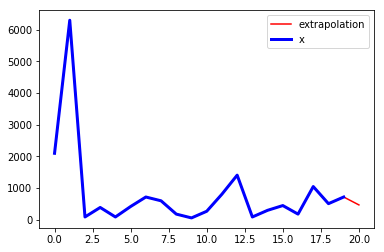

In [263]:
x = X[0]
n_predict = 1
extrapolation = fourierExtrapolation(x, n_predict)
pl.plot(np.arange(0, extrapolation.size), extrapolation, 'r', label = 'extrapolation')
pl.plot(np.arange(0, x.size), x, 'b', label = 'x', linewidth = 3)
pl.legend()
pl.show()

Seems to give logical answers

In [264]:
# Prediction of sales using the fourier extrapolation
y_hat = []
for index, ts in enumerate(X_out):
    if index % 1000 == 0:
        print index,
    y_hat.append(fourierExtrapolation(ts, n_predict)[-1])

0 1000 2000 3000 4000 5000 6000 7000 8000 9000 10000


In [265]:
len(y_hat)

10046

In [270]:
len(y_out)

10046

In [271]:
np.mean(y_out)

4206.1576746963965

In [268]:
X.shape

(10189L, 20L)

In [272]:
MAE = mean_absolute_error(y_hat, y_out)
MAE

1260.8547673184553

In [130]:
np.mean(y_hat)

4734.3364176463338

In [274]:
y_out[0]

480.0

In [275]:
y_hat[0]

470.52631578947603

In [273]:
np.median(y_hat - y_out)

34.849624060152337

So it seems that the biggest errors were done on the pick of sales.

In [143]:
X[-1][:50].shape

(20L,)

In [144]:
y[:50].shape

(50L,)

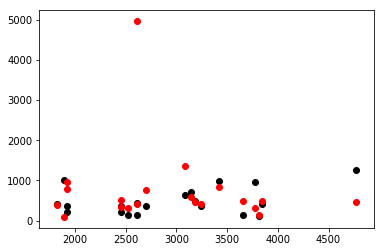

In [145]:
# Plot outputd
plt.scatter(X[-1][:20], y[:20] , color='black')
plt.scatter(X[-1][:20] , y_hat[:20] , color='red')

plt.show()

## Seasonal decomposition

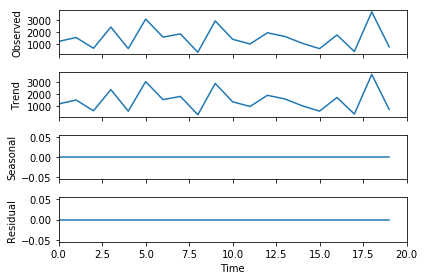

In [146]:
result = seasonal_decompose(X[5000], model='additive', freq=1)
result.plot()
plt.show()

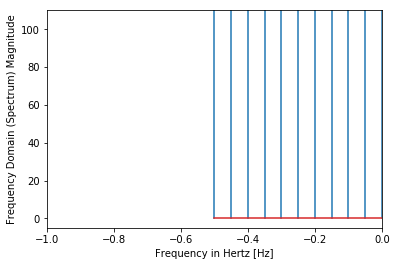

In [147]:
from scipy import fftpack

f_s=1

fX = fftpack.fft(X[0])
freqs = fftpack.fftfreq(len(X[0])) * f_s

fig, ax = plt.subplots()

ax.stem(freqs, np.abs(fX))
ax.set_xlabel('Frequency in Hertz [Hz]')
ax.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax.set_xlim(-f_s / 2, f_s / 2)
ax.set_ylim(-5, 110)

plt.show()

## Periodical feature

In [148]:
Xangle = np.angle(np.fft.fft2(X))

In [149]:
X.shape

(10189L, 20L)

In [150]:
Xangle.shape

(10189L, 20L)

In [151]:
Xperiodic = np.append(Xangle, X, axis=1)

## Regression models

#### Split dataset into test and train datasets

In [167]:
shuffleX, shuffley = shuffle(Xperiodic, y)

In [168]:
shuffleX[:(len(Xperiodic)/5)].shape

(2037L, 40L)

In [169]:
# Take 1/5 of the dataset to test
testX, testy = shuffleX[:(len(Xperiodic)/5)], shuffley[:(len(Xperiodic)/5)]
trainX, trainy = shuffleX[(len(Xperiodic)/5):], shuffley[(len(Xperiodic)/5):]

#### simple model : linear regression

In [170]:
linear = LinearRegression()
linear.fit(trainX, trainy)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [171]:
y_pred = linear.predict(testX)

In [172]:
MAE = mean_absolute_error(y_pred, testy)
MAE

1037.2233410254514

In [173]:
testX.mean()

2185.7334465427316

In [174]:
testX

array([[  2.61633116e+00,  -7.46547650e-01,  -7.91022406e-01, ...,
          2.34000000e+03,   2.07000000e+03,   9.00000000e+02],
       [  1.16663113e+00,  -2.00021667e+00,  -2.03814925e+00, ...,
          3.06000000e+03,   1.71000000e+03,   3.48000000e+03],
       [  1.64411842e+00,   1.19833642e-01,  -6.99860564e-01, ...,
          2.88000000e+03,   1.89000000e+03,   2.97000000e+03],
       ..., 
       [ -3.02276822e+00,  -8.67939139e-02,   4.74036496e-01, ...,
          6.90000000e+02,   1.41000000e+03,   7.20000000e+02],
       [ -2.30813683e+00,  -6.40525079e-01,  -6.15921567e-01, ...,
          5.10000000e+02,   3.00000000e+01,   2.10000000e+02],
       [ -1.41668446e+00,   6.62289868e-01,   3.05834934e+00, ...,
          2.10000000e+02,   2.70000000e+02,   4.80000000e+02]])

In [175]:
testX.shape

(2037L, 40L)

In [176]:
testy.shape

(2037L,)

In [177]:
testX.T[0].shape

(2037L,)

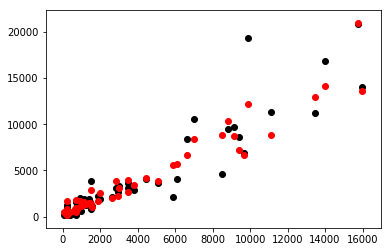

In [178]:
# Plot outputs
plt.scatter(testX.T[-1][:50], testy[:50] , color='black')
plt.scatter(testX.T[-1][:50] , y_pred[:50] , color='red')

plt.show()

#### Polynomial regression

In [180]:
# transformation of feature into a polynomial world
poly = PolynomialFeatures(degree=2)
X_transformed = poly.fit_transform(Xperiodic)

shuffleX, shuffley = shuffle(X_transformed, y)

# Take 1/5 of the dataset to test
testX, testy = shuffleX[:(len(X_transformed)/5)], shuffley[:(len(X_transformed)/5)]
trainX, trainy = shuffleX[(len(X_transformed)/5):], shuffley[(len(X_transformed)/5):]

linear.fit(trainX, trainy)
y_pred = linear.predict(testX)

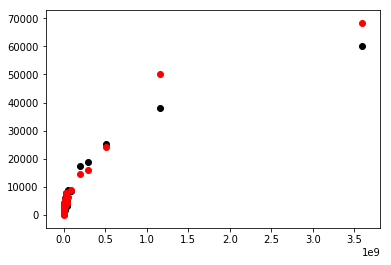

In [181]:
# Plot outputs
plt.scatter(testX.T[-1][:50], testy[:50] , color='black')
plt.scatter(testX.T[-1][:50] , y_pred[:50] , color='red')

plt.show()

In [183]:
np.mean(testy)

4593.8586156111933

In [184]:
MAE = mean_absolute_error(testy, y_pred)
MAE

1260.8301755388482

#### Ridge regression: does the sales volumes are independant ?

In [185]:
ridge = Ridge(alpha=1.0)

shuffleX, shuffley = shuffle(X, y)

# Take 1/5 of the dataset to test
testX, testy = shuffleX[:(len(X)/5)], shuffley[:(len(X)/5)]
trainX, trainy = shuffleX[(len(X)/5):], shuffley[(len(X)/5):]

ridge.fit(trainX, trainy)
y_pred = ridge.predict(testX)

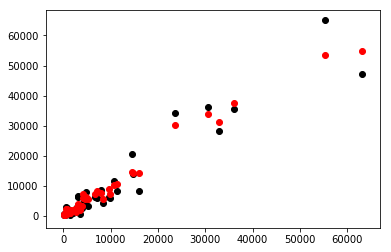

In [186]:
# Plot outputs
plt.scatter(testX.T[-1][:50], testy[:50] , color='black')
plt.scatter(testX.T[-1][:50] , y_pred[:50] , color='red')

plt.show()

In [187]:
MAE = mean_absolute_error(testy, y_pred)
MAE

1051.3494491564375

#### Lasso regression: feature selection -> maybe only last sales volume is usefull for prediction

In [188]:
lasso = Lasso(alpha=0.1, max_iter=10000)

lasso.fit(trainX, trainy)
y_pred = lasso.predict(testX)

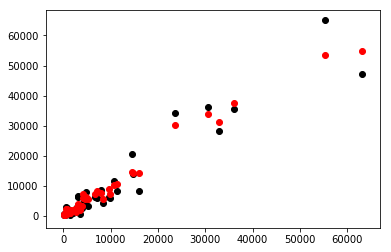

In [189]:
# Plot outputs
plt.scatter(testX.T[-1][:50], testy[:50] , color='black')
plt.scatter(testX.T[-1][:50] , y_pred[:50] , color='red')

plt.show()

In [190]:
MAE = mean_absolute_error(testy, y_pred)
MAE

1051.3494490619405

#### Elastic Net regression

In [191]:
elastic = ElasticNet(random_state=0)
elastic.fit(trainX, trainy)
y_pred = elastic.predict(testX)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.



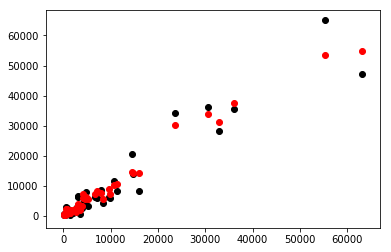

In [192]:
# Plot outputs
plt.scatter(testX.T[-1][:50], testy[:50] , color='black')
plt.scatter(testX.T[-1][:50] , y_pred[:50] , color='red')

plt.show()

In [193]:
MAE = mean_absolute_error(testy, y_pred)
MAE

1051.3590076066362

#### a NN 

In [194]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

regr.fit(trainX, trainy)
y_pred = regr.predict(testX)

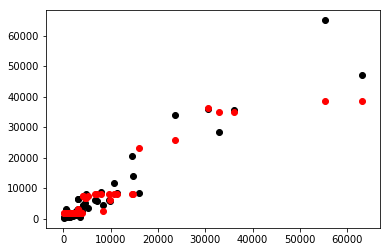

In [195]:
# Plot outputs
plt.scatter(testX.T[-1][:50], testy[:50] , color='black')
plt.scatter(testX.T[-1][:50] , y_pred[:50] , color='red')

plt.show()

In [196]:
MAE = mean_absolute_error(testy, y_pred)
MAE

1713.8492698347129

In [197]:
serie = df2[84146]

In [198]:
len(serie[:-1])

11935

In [199]:
serie[-2:-1]

2017-06-25 21:00:00    30.0
Name: 84146, dtype: float64

In [200]:
X = serie[:-1] 

In [201]:
y = serie[-2: 1]

In [202]:
X.shape

(11935L,)

# Exploratoy variables on surrounding shops

In [6]:
from pandas.io.json import json_normalize

In [14]:
import json

with open('..\UseCase_3_Datasets\Surroundings.json') as json_data:
    d = json.load(json_data)

In [15]:
surroundings = json_normalize(d)
surroundings.head()

,store_code,surroundings.accounting,surroundings.airport,surroundings.amusement_park,surroundings.aquarium,surroundings.art_gallery,surroundings.atm,surroundings.bakery,surroundings.bank,surroundings.bar,...,surroundings.store,surroundings.subway_station,surroundings.synagogue,surroundings.taxi_stand,surroundings.train_station,surroundings.transit_station,surroundings.travel_agency,surroundings.university,surroundings.veterinary_care,surroundings.zoo
0,10055,[{u'name': u'Fiduciaire Exacte & Gestion Compt...,[],[],[],"[{u'website': u'http://www.onegeeinfog.com/', ...",[{u'website': u'https://www.ubs.com/ch/fr.html...,"[{u'name': u'Mconseils SA', u'place_id': u'ChI...","[{u'website': u'http://www.ubs.ch/', u'rating'...","[{u'rating': 3.5, u'place_id': u'ChIJ8xHdm_1vj...",...,[{u'website': u'https://filialen.migros.ch/de/...,[],[],[],[],"[{u'name': u'Chêne-Bourg, La Mousse', u'place_...","[{u'name': u'Courir au Népal Sàrl', u'place_id...",[],[{u'website': u'http://www.vet-chene-bougeries...,[]
1,10077,[],[],[],[],[],[],"[{u'rating': 4.8, u'place_id': u'ChIJM8FbQe9vj...",[],[],...,[{u'website': u'http://www.coop.ch/fr/services...,[],[],[],[],"[{u'name': u'Chêne-Bougeries, Montagne', u'pla...",[],[],[],[]
2,10079,[{u'website': u'http://www.vd.ch/autorites/dep...,[],[],[],[],"[{u'name': u'PickPost-Stelle', u'opening_hours...",[{u'website': u'https://filialen.migros.ch/de/...,[{u'website': u'https://www.ubs.com/ch/fr.html...,[{u'website': u'https://www.facebook.com/Highl...,...,"[{u'website': u'http://www.denner.ch/', u'rati...",[],[],[],[],"[{u'name': u'Yverdon-les-Bains, Bel-Air', u'pl...","[{u'website': u'http://www.hotelplan.ch/FR/', ...",[],[],[]
3,10086,[],[],[],[],[],[],[],[],"[{u'website': u'http://www.oubangui.com/', u'r...",...,"[{u'rating': 3.3, u'place_id': u'ChIJUW-HLeAxj...",[],[],[],[],"[{u'name': u'Bois-Gentil', u'place_id': u'ChIJ...",[],[],[],[]
4,10111,[],[],[],[],[],[],[],[],[],...,"[{u'name': u'lookemontre.com', u'opening_hours...",[],[],[],[],"[{u'name': u'Yverdon-les-Bains, Plaisance', u'...",[],[],[],[]


Examination of informations contained in sub-levels

In [17]:
type(surroundings['surroundings.accounting'][0])

list

In [18]:
len(surroundings['surroundings.accounting'][0])

3

In [19]:
type(surroundings['surroundings.accounting'][0][0])

dict

In [20]:
json_normalize(surroundings['surroundings.accounting'][0]).head()

,address_components,formatted_address,icon,international_phone_number,latitude,longitude,name,opening_hours.open_now,opening_hours.periods,opening_hours.weekday_text,place_id,types,website
0,"[{u'long_name': u'6', u'types': [u'street_numb...","Rue de Genève 6, 1225 Chêne-Bourg, Switzerland",https://maps.gstatic.com/mapfiles/place_api/ic...,+41 22 348 55 28,46.195035,6.192835,Fiduciaire Exacte & Gestion Comptable Isotton ...,False,"[{u'close': {u'day': 1, u'time': u'1700'}, u'o...","[Monday: 9:00 AM – 5:00 PM, Tuesday: 9:00 AM –...",ChIJySk3ff1vjEcR0luLshdJijg,"[accounting, finance, point_of_interest, estab...",NaN
1,"[{u'long_name': u'18', u'types': [u'street_num...","Rue de Genève 18, 1225 Geneve - Chene Bourg, S...",https://maps.gstatic.com/mapfiles/place_api/ic...,+41 22 342 27 01,46.194468,6.194001,Eurex Suisse,NaN,NaN,NaN,ChIJWd4DcNt6jEcRfP0dHwMZr88,"[accounting, finance, point_of_interest, estab...",http://www.eurex.swiss/
2,"[{u'long_name': u'13', u'types': [u'street_num...","Rue du Vieux-Chêne 13, 1224 Chêne-Bougeries, S...",https://maps.gstatic.com/mapfiles/place_api/ic...,+41 79 561 99 39,46.195345,6.191545,Compta-Magda Sàrl,True,"[{u'close': {u'day': 1, u'time': u'1730'}, u'o...","[Monday: 9:00 AM – 5:30 PM, Tuesday: 9:00 AM –...",ChIJE0A1j_1vjEcR1Vv1H1M6hEU,"[accounting, finance, point_of_interest, estab...",http://www.compta-magda.ch/


In [21]:
json_normalize(surroundings['surroundings.art_gallery'][0]).head()

,address_components,formatted_address,icon,latitude,longitude,name,place_id,types,website
0,"[{u'long_name': u'25', u'short_name': u'25', u...","Rue de Genève 25, 1225 Chêne-Bourg, Switzerland",https://maps.gstatic.com/mapfiles/place_api/ic...,46.194393,6.195039,One Gee In Fog,ChIJ7YfhUh1wjEcRT6flX_wm1Lw,"[art_gallery, point_of_interest, establishment]",http://www.onegeeinfog.com/


Some of the information are not useful or redondant